# Setup for desired circuit

In this example, the `cirq` library is installed as a prerequisite.

In [1]:
!pip install cirq

In [2]:
from typing import List, Tuple

import cirq
import numpy as np
from braket.ir.jaqcd.program_v1 import Results
from cirq import (
    Circuit,
)

from translations import (
    CIRQ_GATES,
    cirq_gate_to_instruction,
    get_cirq_qubits,
)
from braket.default_simulator.openqasm.program_context import AbstractProgramContext
from braket.default_simulator.openqasm.interpreter import Interpreter

## Create a translations.py-like File for Gate Mapping

Inherit AbstractProgramContext and define the abstract methods

- The `AbstractProgramContext` class represents the context or state of an interpreter for a program. It provides a framework for managing symbols, variables, gates, subroutines, qubit mappings, and the program circuit.


- The AbstractProgramContext class is an abstract base class (ABC) that defines the common structure and functionality expected in a program context. 

- It serves as a blueprint for creating concrete program contexts by defining a set of abstract methods and attributes that must be implemented by the subclasses. 

- Key attributes of the AbstractProgramContext include the symbol table, variable table, gate table, subroutine table, qubit mapping table, and the program circuit. 

- The circuit attribute represents the intermediate representation (IR) of the program that is built and handed off to the simulator or executor. 

- Various other methods, such as add_gate, get_gate_definition, is_user_defined_gate, add_subroutine, and get_subroutine_definition, enable gate and subroutine management within the program. 

- The AbstractProgramContext defines abstract methods for adding results, phase instructions, gate instructions, custom unitaries, and noise instructions to the program. 

In [3]:
class CirqProgramContext(AbstractProgramContext):
    def __init__(self):
        super().__init__(Circuit())

    def is_builtin_gate(self, name: str) -> bool:
        """Whether the gate is currently in scope as a built-in Braket gate.

        Args:
            name (str): name of the built-in Braket gate

        Returns:
            bool: return TRUE if it is a built-in gate else FALSE.
        """
        user_defined_gate = self.is_user_defined_gate(name)
        return name in CIRQ_GATES and not user_defined_gate

    def add_phase_instruction(self, target: Tuple[int], phase_value: int):
        raise NotImplementedError

    def add_gate_instruction(
        self, gate_name: str, target: Tuple[int], params, ctrl_modifiers: List[int], power: int
    ):
        """Add Braket gate to the circuit.

        Args:
            gate_name (str): name of the gate.
            target (Tuple[int]): control_qubits + target_qubits.
            ctrl_modifiers (List[int]): Quantum state on which to control the
                operation. Must be a binary sequence of same length as number of qubits in
                `control_qubits` in target. For example "0101", [0, 1, 0, 1], 5 all represent
                controlling on qubits 0 and 2 being in the \\|0⟩ state and qubits 1 and 3 being
                in the \\|1⟩ state.
            power(float): Integer or fractional power to raise the gate to.
        """
        qubits = get_cirq_qubits(target)
        target_cirq_qubits = qubits[len(ctrl_modifiers) :]
        control_qubits = qubits[: len(ctrl_modifiers)]

        if params:
            gate = CIRQ_GATES[gate_name](*params).on(*target_cirq_qubits)
        else:
            gate = CIRQ_GATES[gate_name].on(*target_cirq_qubits)
        ctrl_modifiers = [bit ^ 1 for bit in ctrl_modifiers]
        gate = gate.controlled_by(*control_qubits, control_values=ctrl_modifiers)
        gate = gate**power

        self.circuit.append(gate)

    def add_custom_unitary(
        self,
        unitary: np.ndarray,
        target: Tuple[int],
    ) -> None:
        """Add a custom Unitary instruction to the circuit

        Args:
            unitary (np.ndarray): unitary matrix
            target (Tuple[int]): control_qubits + target_qubits
        """
        qubits = get_cirq_qubits(target)
        instruction = cirq.MatrixGate(unitary).on(*qubits)
        self.circuit.append(instruction)

    def add_noise_instruction(self, noise):
        """Add a noise instruction the circuit"""
        instruction = cirq_gate_to_instruction(noise)
        self.circuit.append(instruction)

    def add_result(self, result: Results) -> None:
        """Add a result type to the circuit"""
        raise NotImplementedError


## Basic gates example
This section showcases an example of basic gates. An OpenQASM program is defined, and a Circ circuit is built using the `Interpreter` and `CirqProgramContext` classes.

In [4]:
openqasm = """
            OPENQASM 3.0;
            bit[1] b;
            qubit[1] q;
            h q[0];
           """

basic_cirq_circuit = Interpreter(CirqProgramContext()).build_circuit(
        source=openqasm,
    )
# print(cirq.final_state_vector(basic_cirq_circuit))
basic_cirq_circuit.append(cirq.measure(*basic_cirq_circuit.all_qubits()))
print(basic_cirq_circuit)


0: ───H───M───


/var/folders/tb/2yh3yjmn3196046lsp7n2m5r0000gr/T/ipykernel_60904/3355952321.py:39: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if params:


## Running basic circuit on simulator

The simulator runs the circuit with a specified number of repetitions, and the results are displayed in a state histogram plot

q(0)=0111110010


/Users/spchit/workspace/forks/amazon-braket-examples/venv/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

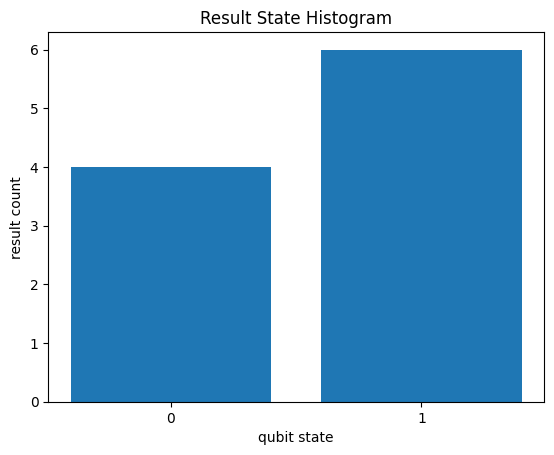

In [5]:
from cirq import plot_state_histogram as plt_hist

simulator = cirq.Simulator()

result = simulator.run(basic_cirq_circuit, repetitions=10)

print(result)
plt_hist(result)

## Noise Gate example

In [6]:
openqasm = """
            OPENQASM 3.0;
            bit[1] b;
            qubit[1] q;
            x q[0];
            #pragma braket noise bit_flip(0.1) q[0]
            b[0] = measure q[0];
            """
noise_cirq_circuit = Interpreter(CirqProgramContext()).build_circuit(
        source=openqasm,
    )
noise_cirq_circuit.append(cirq.measure(*basic_cirq_circuit.all_qubits()))
print(noise_cirq_circuit)
# cirq.final_density_matrix(noise_cirq_circuit)

0: ───X───BF(0.1)───M───


/var/folders/tb/2yh3yjmn3196046lsp7n2m5r0000gr/T/ipykernel_60904/3355952321.py:39: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if params:


## Running noise circuits on cirq simulator

q(0)=1111111111111011111111101111111111011111111111011111111111111111111111111111110111111111111110111111


/Users/spchit/workspace/forks/amazon-braket-examples/venv/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: title={'center': 'Result State Histogram'}, xlabel='qubit state', ylabel='result count'>

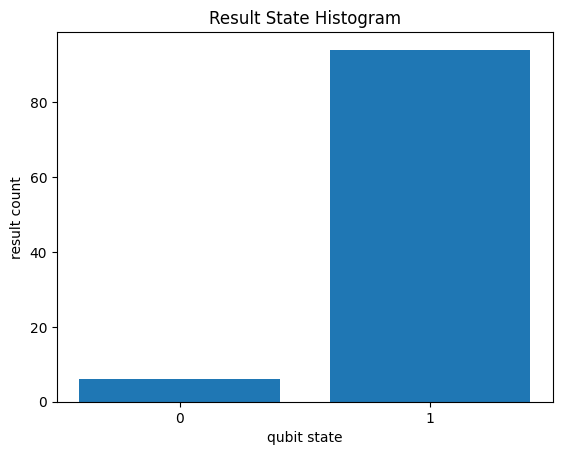

In [7]:
from cirq import plot_state_histogram as plt_hist

result = simulator.run(noise_cirq_circuit, repetitions=100)

print(result)
plt_hist(result)

## Instructions to add a cirq as one of the local simulators in Braket Simulators.

This section provides instructions for adding Cirq as a local simulator in Braket Simulators. It includes creating a `cirq_simulator.py` file within the `braket.default_simulator.cirq` folder, defining a `CirqSimulator` class, and implementing necessary methods for initialization, circuit execution, and result generation.

```
import sys
import uuid

import cirq
from braket.device_schema.simulators import (
    GateModelSimulatorDeviceCapabilities,
    GateModelSimulatorDeviceParameters,
)
from braket.ir.openqasm import Program as OpenQASMProgram
from braket.task_result import GateModelTaskResult, TaskMetadata, AdditionalMetadata
from cirq import Simulator

from braket.default_simulator.cirq.cirq_program_context import CirqProgramContext
from braket.default_simulator.openqasm.interpreter import Interpreter
from braket.simulator import BraketSimulator


class CirqSimulator(BraketSimulator):
    DEVICE_ID = "cirq"

    def initialize_simulation(self):
        """
        Initialize cirq simulation.


        Returns:
            cirq.Simulator: Initialized simulation.
        """
        return Simulator()

    def run(self, circuit_ir: OpenQASMProgram, *args, **kwargs):
        return self.run_openqasm(circuit_ir, *args, **kwargs)

    def run_openqasm(
        self,
        circuit_ir: OpenQASMProgram,
        shots: int = 1,
    ) -> GateModelTaskResult:
        is_file = circuit_ir.source.endswith(".qasm")
        interpreter = Interpreter(context=CirqProgramContext())
        circuit = interpreter.build_circuit(
            source=circuit_ir.source,
            inputs=circuit_ir.inputs,
            is_file=is_file,
        )
        circuit.append(cirq.measure(*circuit.all_qubits()))
        simulation = self.initialize_simulation()
        result = simulation.run(circuit, repetitions=shots)
        return self._create_results_obj(circuit_ir, result)

    def _get_measured_qubits(self, result):
        measured_qubits = set()
        for key in result.measurements.keys():
            measured_qubits.update([qubit[qubit.index("(") + 1 : -1] for qubit in key.split(",")])
        return list(measured_qubits)

    def _create_results_obj(
        self,
        circuit_ir: OpenQASMProgram,
        result: cirq.Result,
    ) -> GateModelTaskResult:
        return GateModelTaskResult.construct(
            taskMetadata=TaskMetadata(
                id=str(uuid.uuid4()),
                shots=result.repetitions,
                deviceId=self.DEVICE_ID,
            ),
            additionalMetadata=AdditionalMetadata(
                action=circuit_ir,
            ),
            measurements=list(list(result.measurements.values())[0]),
            measuredQubits=self._get_measured_qubits(result),
        )

    @property
    def properties(self):
        max_shots = sys.maxsize
        return GateModelSimulatorDeviceCapabilities.parse_obj(
            {
                "service": {
                    "executionWindows": [
                        {
                            "executionDay": "Everyday",
                            "windowStartHour": "00:00",
                            "windowEndHour": "23:59:59",
                        }
                    ],
                    "shotsRange": [0, max_shots],
                },
                "action": {
                    "braket.ir.openqasm.program": {
                        "actionType": "braket.ir.openqasm.program",
                        "version": ["1"],
                        "supportedOperations": [
                            # builtin Braket gates
                            "ccnot",
                            "cnot",
                            "cphaseshift",
                            "cswap",
                            "h",
                            "i",
                            "iswap",
                            "rx",
                            "ry",
                            "rz",
                            "s",
                            "swap",
                            "t",
                            "x",
                            "y",
                            "z",
                        ],
                        "supportedModifiers": [
                            {
                                "name": "ctrl",
                            },
                            {
                                "name": "negctrl",
                            },
                            {
                                "name": "pow",
                                "exponent_types": ["int", "float"],
                            },
                            {
                                "name": "inv",
                            },
                        ],
                        "supportedPragmas": [
                            "braket_unitary_matrix",
                            "braket_result_type_state_vector",
                            "braket_result_type_density_matrix",
                            "braket_result_type_sample",
                            "braket_result_type_expectation",
                            "braket_result_type_variance",
                            "braket_result_type_probability",
                            "braket_result_type_amplitude",
                            "braket_noise_bit_flip",
                            "braket_noise_depolarizing",
                            "braket_noise_generalized_amplitude_damping",
                            "braket_noise_phase_flip",
                            "braket_noise_phase_damping",
                        ],
                        "forbiddenPragmas": [
                            "braket_noise_amplitude_damping",
                            "braket_noise_kraus",
                            "braket_noise_pauli_channel",
                            "braket_noise_two_qubit_dephasing",
                            "braket_noise_two_qubit_depolarizing",
                            "braket_result_type_adjoint_gradient",
                        ],
                        "supportPhysicalQubits": False,
                        "supportsPartialVerbatimBox": False,
                        "requiresContiguousQubitIndices": True,
                        "requiresAllQubitsMeasurement": True,
                        "supportsUnassignedMeasurements": True,
                        "disabledQubitRewiringSupported": False,
                    },
                },
                "deviceParameters": GateModelSimulatorDeviceParameters.schema(),
            }
        )

```


### In amazon-braket-default-simulator-python package add the following in entry_points in setup.py
```
entry_points={
        "braket.simulators": [
            ...
            "cirq = braket.default_simulator.cirq.cirq_simulator:CirqSimulator",
            ...
            }
```


### Running a braket circuit on the local simulator defined above

```
from braket.circuits import Circuit
from braket.circuits.serialization import IRType
from braket.devices import LocalSimulator

dev = LocalSimulator("cirq")
braket_circuit = Circuit().h(0)
openqasm_program = braket_circuit.to_ir(IRType.OPENQASM)
result = dev.run(openqasm_program, shots=10).result()
print(result.measurements)
```